# Create plots for panels used in figure 5

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import dclab

import warnings
warnings.filterwarnings('ignore')

In [2]:
result_folder = r"data\RTfDC\WBC"

# folder to save all panels for figure #
savefolder = r"plots\fig5"

Manually add means for missing data for LM-9w-20171107

In [3]:
data_LM_9w_lympho = {'date': '2017-11-07','events': 77, 'flow rate': 0.08, '% gated': 8.43,
                     'median area_um': 39., 'mean area_um': 38., 'sd area_um': 5.5,
                     'median deform': 0.0264, 'mean deform': 0.0316, 'sd deform': 0.0154}
data_LM_9w_myelo = {'date': '2017-11-07','events': 47, 'flow rate': 0.08, '% gated': 5.15,
                     'median area_um': 63.3, 'mean area_um': 64.1, 'sd area_um': 5.68,
                     'median deform': 0.0319, 'mean deform': 0.0378, 'sd deform': 0.017}

Plot results with gates from brighntess plot (created 20200521)

In [4]:
lympho_ctrl_medians = {'area_um': 37.88789749145508,
                       'deform': 0.04369187355041504,
                       'emodulus': 0.7527109307300333}
myelo_ctrl_medians = {'area_um': 64.04239654541016,
                      'deform': 0.08041012287139893,
                      'emodulus': 0.7098496091718063}

In [5]:
def plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize= 28, figsize=(8,6)):

    flow_rate = 0.08

    linewidth = 6
    markersize = 15
    #errorbar formatting
    markerwidth = 12
    errbar_width = 8

    try:
        ylabel = dclab.dfn.feature_name2label[y_value]
    except:
        ylabel = y_value

    color_dict = {'VS': 'C0', 'VL': 'C1', 'RS': 'C2',
                  'KM': 'C3', 'LM': 'C4'}

    if cell_type == "lymphos":
        plot_title = "Lymphocytes"
        ctrl_value = lympho_ctrl_medians[y_value]
    elif cell_type == "myelos":
        plot_title = "Myelocytes"
        ctrl_value = myelo_ctrl_medians[y_value]

    with sns.axes_style('darkgrid'):
        fig = plt.figure(0, figsize)
        ax1 = plt.subplot(111)

        ax_xlabel = "Day since treatment start"
        ax_ylabel = dclab.dfn.feature_name2label[y_value]

        ax1.set_xlabel(ax_xlabel, fontsize=fontsize)
        ax1.set_ylabel(ax_ylabel, fontsize=fontsize)

        ax1.axhline(ctrl_value, c='darkgray', alpha=.75, ls='--', lw=1.5*linewidth, label='CTRL')

        for ind, patient in enumerate(patients):

            result_file = "20200522_results_" + patient + "_" + cell_type + ".tsv"
            result_path = os.path.join(result_folder, result_file)

            df = pd.read_csv(result_path, sep='\t')

            if y_value=='emodulus':
                emod = dclab.features.emodulus.get_emodulus(area_um=df['area_um'],
                                                          deform=df['deform'],
                                                          medium="CellCarrier",
                                                          channel_width=20.0,
                                                          flow_rate=flow_rate)
                df['emodulus'] = emod

            df_date_grouped_mean = df.groupby(['date', 'flow rate']).median().reset_index()
            if err_type=='std':
                df_date_grouped_std = df.groupby(['date', 'flow rate']).std().reset_index()
            if err_type=='sem':
                df_date_grouped_sem = df.groupby(['date', 'flow rate']).sem().reset_index()

            dates = pd.to_datetime(df_date_grouped_mean.reset_index()['date'])
            day0=dates[0]

            time = dates - day0

            df_date_grouped_mean['delta_days'] = time.dt.days #convert datetime in ns to days
            if err_type=='std':
                df_date_grouped_std['delta_days'] = time.dt.days
            if err_type=='sem':
                df_date_grouped_sem['delta_days'] = time.dt.days

            color = color_dict[patient]

            #flow rate range from 0.004 - 0.02 ul/s
            ii = np.round(df_date_grouped_mean['flow rate'], 3) == flow_rate
            x = df_date_grouped_mean['delta_days'][ii]
            y = df_date_grouped_mean[y_value][ii]
            if err_type=='std':
                yerr = df_date_grouped_std[y_value][ii]
            if err_type=='sem':
                yerr = df_date_grouped_sem[y_value][ii]

            x = np.array(x)
            y = np.array(y)
            yerr = np.array(yerr)

            if patient=='LM':
                if cell_type == 'lymphos':
                    dict_LM_9w = data_LM_9w_lympho
                if cell_type == 'myelos':
                    dict_LM_9w = data_LM_9w_myelo

                date_LM_9w = pd.to_datetime(dict_LM_9w['date'])
                time_LM_9w = (date_LM_9w - day0).days

                if y_value=='emodulus':
                    area = dict_LM_9w['median area_um']
                    deform = dict_LM_9w['median deform']
                    y_LM_9w = dclab.features.emodulus.get_emodulus(area_um=area,
                                                          deform=deform,
                                                          medium="CellCarrier",
                                                          channel_width=20.0,
                                                          flow_rate=flow_rate)
                    yerr_LM_9w = 0
                else:
                    y_LM_9w = dict_LM_9w['median ' + y_value]

                    if err_type=='std':
                        yerr_LM_9w = dict_LM_9w['sd ' + y_value]
                    if err_type=='sem':
                        yerr_LM_9w = dict_LM_9w['sd ' + y_value]/np.sqrt(dict_LM_9w['events'])

                x = np.insert(x,1,time_LM_9w)
                y = np.insert(y,1,y_LM_9w)
                yerr = np.insert(yerr,1,yerr_LM_9w)

            if patient=='LM':
                ax1.errorbar(x[:-2],y[:-2], yerr=yerr[:-2], ls='-', lw=linewidth, marker='o', c=color, ecolor='gray',
                             markersize = markersize, elinewidth=errbar_width, label = labels[ind])
                ax1.errorbar(x[-3:],y[-3:], yerr=yerr[-3:], ls='--', lw=linewidth, marker='o', c=color, ecolor='gray',
                            markersize = markersize, elinewidth=errbar_width)
            else:
                ax1.errorbar(x[:-1],y[:-1], yerr=yerr[:-1], ls='-', lw=linewidth, marker='o', c=color, ecolor='gray',
                             markersize = markersize, elinewidth=errbar_width, label = labels[ind])
                ax1.errorbar(x[-2:],y[-2:], yerr=yerr[-2:], ls='--', lw=linewidth, marker='o', c=color, ecolor='gray',
                            markersize = markersize, elinewidth=errbar_width)

        if 'LM' in patients:
            ax1.legend(fontsize=fontsize-4, ncol=1)
        else:
            ax1.legend(fontsize=fontsize-4, ncol=2)
        ax1.tick_params(axis='both', labelsize=fontsize-2)
        plt.title(plot_title, fontsize=fontsize+2)
        plt.tight_layout()

        #set alpha of errorbars
        for collection in ax1.collections:
            collection.set_alpha(.25)

    return fig, ax1

## A

[None, None]

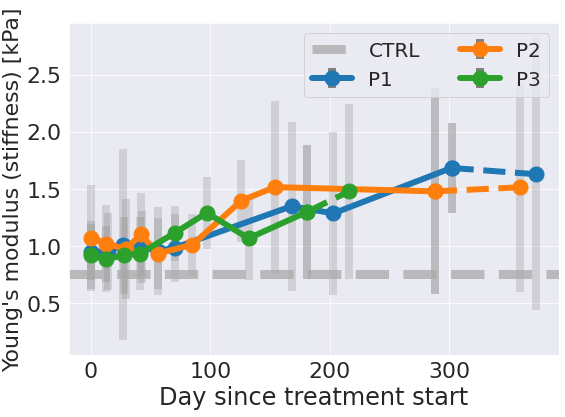

In [16]:
patients = ['VS', 'VL', 'RS']
labels = ['P1', 'P2', 'P3']
cell_type = "lymphos"
y_value = 'emodulus'

fontsize=24
fig, ax = plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize=fontsize)
ax.set_title("")
ax.set_ylabel("Young's modulus (stiffness) [kPa]", fontsize=fontsize-2)
fig.set(figwidth=8, figheight=6)

In [17]:
save_name = "fig5A_lympho_dasatinib_emod"
savepath = os.path.join(savefolder,save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

## B

[None, None]

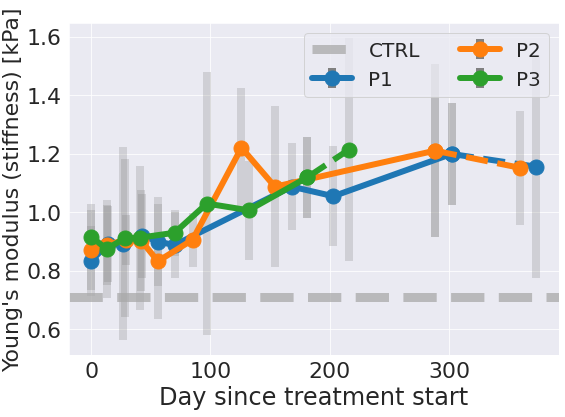

In [18]:
patients = ['VS', 'VL', 'RS']
labels = ['P1', 'P2', 'P3']
cell_type = "myelos"
y_value = 'emodulus'

fontsize=24
fig, ax = plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize=fontsize)
ax.set_ylabel("Young's modulus (stiffness) [kPa]", fontsize=fontsize-2)
ax.set_title("")
fig.set(figwidth=8, figheight=6)

In [19]:
save_name = "fig5B_lympho_dasatinib_emod"
savepath = os.path.join(savefolder,save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

## C

[None, None]

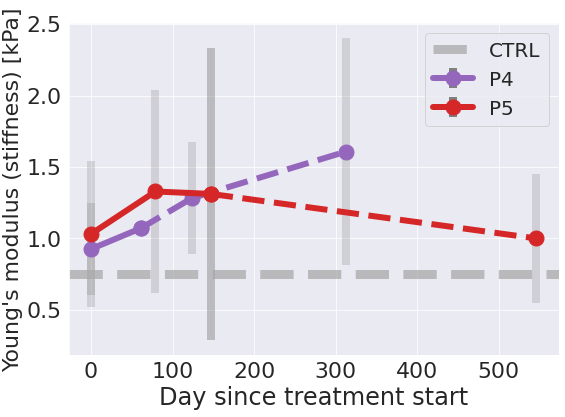

In [20]:
patients = ['LM', 'KM']
labels = ['P4', 'P5']
cell_type = "lymphos"
y_value = 'emodulus'

fontsize=24
fig, ax = plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize=fontsize)
ax.set_ylabel("Young's modulus (stiffness) [kPa]", fontsize=fontsize-2)
ax.set_title("")
fig.set(figwidth=8, figheight=6)

In [21]:
save_name = "fig5C_lympho_lithium_emod"
savepath = os.path.join(savefolder,save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

## D

[None, None]

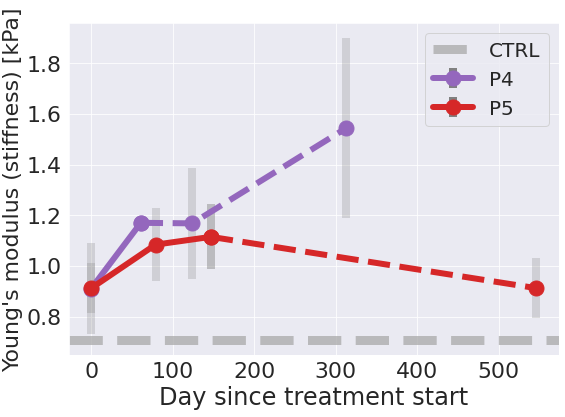

In [22]:
patients = ['LM', 'KM']
labels = ['P4', 'P5']
cell_type = "myelos"
y_value = 'emodulus'

fontsize=24
fig, ax = plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize=fontsize)
ax.set_ylabel("Young's modulus (stiffness) [kPa]", fontsize=fontsize-2)
ax.set_title("")
fig.set(figwidth=8, figheight=6)

In [23]:
save_name = "fig5D_myelo_lithium_emod"
savepath = os.path.join(savefolder,save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')